### Importación de librerias


In [79]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math 
import numba as nb
from numba import njit

### Codigo sencillo para honeycomb

In [80]:


## Funcion para definir los nodos de forma aleatoria 

def build_system(L, q):
    """Construye el sistema con spins aleatorios en una red honeycomb diluida"""
    N = 2 * L * L
    n = int(q * N)
    Ss = np.zeros((L, L, 2), dtype=int)
    posiciones_totales = [(i, j, u) for i in range(L) for j in range(L) for u in range(2)]
    random.shuffle(posiciones_totales)
    posiciones_ocupadas = []
    
    for k in range(n):
        i, j, u = posiciones_totales[k]
        Ss[i, j, u] = random.choice([-1, 1])
        posiciones_ocupadas.append((i, j, u))
    
    return Ss, posiciones_ocupadas, n

def get_neighbors(i, j, u, L):
    """Retorna los vecinos en la red honeycomb con condiciones periódicas"""
    if u == 0:  # Sublattice A
        return [
            (i % L, j % L, 1),
            (i % L, (j - 1) % L, 1),
            ((i - 1) % L, j % L, 1)
        ]
    else:  # Sublattice B
        return [
            (i % L, j % L, 0),
            (i % L, (j + 1) % L, 0),
            ((i + 1) % L, j % L, 0)
        ]

def delta_energy(spin, i, j, u, H, J, L):
    """Calcula el cambio de energía al flipear un spin"""
    sigma = spin[i, j, u]
    neighbors = get_neighbors(i, j, u, L)
    sum_vecinos = sum(spin[ni, nj, nu] for ni, nj, nu in neighbors if spin[ni, nj, nu] != 0)
    energia_local = -J * sigma * sum_vecinos + sigma * H
    return 2 * energia_local

def simulate(L, q, J, H, T, steps_equil=10000, steps_meas=10000, measure_every=100):
    """Simula una realización del sistema usando Monte Carlo (Metropolis)"""
    spin, occupied, n = build_system(L, q)
    if n == 0:
        return 0.0
    
    suma_spins = np.sum(spin)
    
    # Fase de equilibración
    for _ in range(steps_equil):
        i, j, u = random.choice(occupied)
        Delta_E = delta_energy(spin, i, j, u, H, J, L)
        if Delta_E <= 0 or math.exp(-Delta_E / T) > random.random():
            suma_spins -= 2 * spin[i, j, u]
            spin[i, j, u] *= -1
    
    # Fase de medición
    m_samples = []
    for step in range(steps_meas):
        i, j, u = random.choice(occupied)
        Delta_E = delta_energy(spin, i, j, u, H, J, L)
        if Delta_E <= 0 or math.exp(-Delta_E / T) > random.random():
            suma_spins -= 2 * spin[i, j, u]
            spin[i, j, u] *= -1
        
        if step % measure_every == 0:
            m = suma_spins / n
            m_samples.append(m)
    
    return np.mean(m_samples)

def simulate_ensemble(L, q, J, H, T, num_realizaciones=10, steps_equil=10000, 
                     steps_meas=10000, measure_every=100):
    """Promedia sobre múltiples realizaciones del desorden"""
    m_locals = []
    for _ in range(num_realizaciones):
        m_local = simulate(L, q, J, H, T, steps_equil, steps_meas, measure_every)
        m_locals.append(m_local)
    
    m_final = np.mean(m_locals)
    error = np.std(m_locals) / np.sqrt(num_realizaciones)
    return m_final, error






L = 10
q = 0.8
J = 1.0
H = 0.0
T = 2.0
num_realizaciones = 10

m, err = simulate_ensemble(L, q, J, H, T, num_realizaciones)
print(f"Magnetización promedio (ensemble): {m} ± {err}")

Magnetización promedio (ensemble): -0.0009375000000000002 ± 0.0023815862623470098


### Codigo optimizado para honeycomb

In [81]:

## Codigo completo de con numba
## Función para definir los nodos de forma aleatoria
def build_system(L, q):
    """Construye el sistema con spins aleatorios en una red honeycomb diluida"""
    N = 2 * L * L
    n = int(q * N)
    Ss = np.zeros((L, L, 2), dtype=np.int32)
    if n == 0:
        return Ss, np.zeros((0, 3), dtype=np.int32), 0
    
    # Generar todas las posiciones
    i_coords = np.repeat(np.arange(L), L * 2)
    j_coords = np.tile(np.repeat(np.arange(L), 2), L)
    u_coords = np.tile(np.arange(2), L * L)
    all_pos = np.column_stack((i_coords, j_coords, u_coords))
    
    # Seleccionar posiciones ocupadas aleatoriamente
    idx = np.random.choice(N, n, replace=False)
    posiciones_ocupadas = all_pos[idx]
    
    # Asignar spins aleatorios
    signs = np.random.choice(np.array([-1, 1], dtype=np.int32), n)
    Ss[posiciones_ocupadas[:, 0], posiciones_ocupadas[:, 1], posiciones_ocupadas[:, 2]] = signs
    
    return Ss, posiciones_ocupadas, n

@njit
def delta_energy(spin, i, j, u, H, J, L):
    """Calcula el cambio de energía al flipear un spin"""
    sigma = spin[i, j, u]
    sum_vecinos = 0
    
    if u == 0:  # Sublattice A
        n1i, n1j, n1u = i % L, j % L, 1
        n2i, n2j, n2u = i % L, (j - 1) % L, 1
        n3i, n3j, n3u = (i - 1) % L, j % L, 1
    else:  # Sublattice B
        n1i, n1j, n1u = i % L, j % L, 0
        n2i, n2j, n2u = i % L, (j + 1) % L, 0
        n3i, n3j, n3u = (i + 1) % L, j % L, 0
    
    if spin[n1i, n1j, n1u] != 0:
        sum_vecinos += spin[n1i, n1j, n1u]
    if spin[n2i, n2j, n2u] != 0:
        sum_vecinos += spin[n2i, n2j, n2u]
    if spin[n3i, n3j, n3u] != 0:
        sum_vecinos += spin[n3i, n3j, n3u]
    
    energia_local = -J * sigma * sum_vecinos + sigma * H
    return 2 * energia_local

@njit
def equilibration(spin, occupied, suma_spins, L, n, steps_equil, H, J, T):
    for _ in range(steps_equil):
        k = np.random.randint(n)
        i = occupied[k, 0]
        j = occupied[k, 1]
        u = occupied[k, 2]
        Delta_E = delta_energy(spin, i, j, u, H, J, L)
        if Delta_E <= 0 or np.exp(-Delta_E / T) > np.random.rand():
            suma_spins -= 2 * spin[i, j, u]
            spin[i, j, u] = -spin[i, j, u]
    return suma_spins

@njit
def measurement(spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every):
    num_samples = (steps_meas // measure_every) + 1 if steps_meas % measure_every != 0 else (steps_meas // measure_every)
    m_samples = np.zeros(num_samples)
    cnt = 0
    for step in range(steps_meas):
        k = np.random.randint(n)
        i = occupied[k, 0]
        j = occupied[k, 1]
        u = occupied[k, 2]
        Delta_E = delta_energy(spin, i, j, u, H, J, L)
        if Delta_E <= 0 or np.exp(-Delta_E / T) > np.random.rand():
            suma_spins -= 2 * spin[i, j, u]
            spin[i, j, u] = -spin[i, j, u]
        if step % measure_every == 0:
            m_samples[cnt] = suma_spins / n
            cnt += 1
    return m_samples[:cnt]

def simulate(L, q, J, H, T, steps_equil=10000, steps_meas=10000, measure_every=100):
    """Simula una realización del sistema usando Monte Carlo (Metropolis)"""
    spin, occupied, n = build_system(L, q)
    if n == 0:
        return 0.0
    
    # ⬅️ ✅ CORRECCIÓN: Calcular suma solo de spins ocupados
    suma_spins = 0
    for k in range(n):
        i, j, u = occupied[k]
        suma_spins += spin[i, j, u]
    
    # Fase de equilibración
    suma_spins = equilibration(spin, occupied, suma_spins, L, n, steps_equil, H, J, T)
    
    # Fase de medición
    m_samples = measurement(spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every)
    
    return np.mean(m_samples)

def simulate_ensemble(L, q, J, H, T, num_realizaciones=10, steps_equil=10000,
                      steps_meas=10000, measure_every=100):
    """Promedia sobre múltiples realizaciones del desorden"""
    m_locals = []
    for _ in range(num_realizaciones):
        m_local = simulate(L, q, J, H, T, steps_equil, steps_meas, measure_every)
        m_locals.append(m_local)
    m_final = np.mean(m_locals)
    error = np.std(m_locals) / np.sqrt(num_realizaciones)
    return m_final, error

# ============ PRUEBA ============
L = 10
q = 0.8
J = 1.0
H = 0.0
T = 2.0
num_realizaciones = 10

print("⏳ Ejecutando simulación optimizada con Numba...")
m, err = simulate_ensemble(L, q, J, H, T, num_realizaciones)
print(f"✅ Magnetización promedio (ensemble): {m:.6f} ± {err:.6f}")

⏳ Ejecutando simulación optimizada con Numba...
✅ Magnetización promedio (ensemble): -0.000163 ± 0.001724
✅ Magnetización promedio (ensemble): -0.000163 ± 0.001724


### Variacion de parametros
Para la realización de ising_honeycomb haré la variación de parametros

H va desde -25 a 25
L = 10
z=3
J = 1.0 (caso paramagnetico)
q=0, 0.5 y 0.8
T=4,10,20 kelvin


Graficas juntas de q fijo y variacion de temperaturas

🔄 Iniciando simulaciones m vs H para red honeycomb...
✅ Simulaciones completadas

✅ Simulaciones completadas



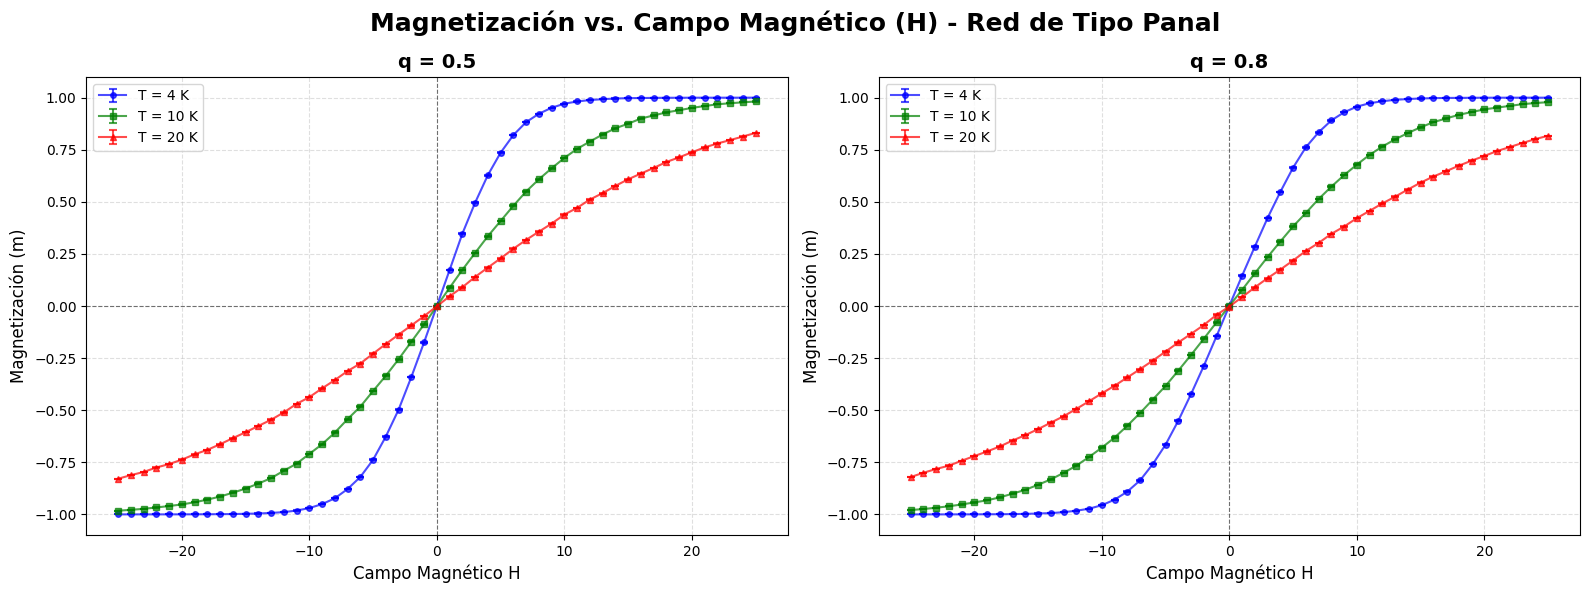

In [82]:
### Gráficas de Magnetización vs Campo Magnético (H) - Red Honeycomb

# --- Parámetros de simulación ---
L = 10
J = 1.0
H_values = np.linspace(-25, 25, 51)  # 51 puntos
q_values = [0.5, 0.8]
T_values = [4, 10, 20]
num_realizaciones = 20
steps_equil = 10000
steps_meas = 20000
measure_every = 100

print("🔄 Iniciando simulaciones m vs H para red honeycomb...")

# Diccionario para almacenar resultados
results = {}

# --- Simulación ---
for q in q_values:
    for T in T_values:
        magnetizations = []
        errors = []
        
        for H in H_values:
            m, err = simulate_ensemble(
                L=L, q=q, J=J, H=H, T=T,
                num_realizaciones=num_realizaciones,
                steps_equil=steps_equil,
                steps_meas=steps_meas,
                measure_every=measure_every
            )
            magnetizations.append(m)
            errors.append(err)
        
        results[(q, T)] = {'m': magnetizations, 'err': errors}

print("✅ Simulaciones completadas\n")

# --- Visualización: 2 gráficas (una por q) ---
fig, axes = plt.subplots(1, len(q_values), figsize=(16, 6))
fig.suptitle('Magnetización vs. Campo Magnético (H) - Red de Tipo Panal', 
             fontsize=18, fontweight='bold')

colors = ['blue', 'green', 'red']
markers = ['o', 's', '^']

for i, q in enumerate(q_values):
    ax = axes[i]
    
    # Graficar cada temperatura en la misma gráfica
    for j, T in enumerate(T_values):
        res = results[(q, T)]
        ax.errorbar(
            H_values, 
            res['m'],
            yerr=res['err'],
            fmt=f'-{markers[j]}', 
            markersize=4, 
            color=colors[j],
            label=f'T = {T} K',
            capsize=3,
            capthick=1.5,
            elinewidth=1.5,
            alpha=0.7
        )
    
    # Configuración de la gráfica
    ax.set_title(f'q = {q}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Campo Magnético H', fontsize=12)
    ax.set_ylabel('Magnetización (m)', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend(loc='best', fontsize=10)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)

plt.tight_layout()
plt.show()


### Grafica de relajación

In [83]:
### Funciones adicionales para análisis de relajación energética

@njit
def calculate_total_energy(spin, occupied, L, J, H):
    """Calcula la energía total del sistema"""
    n = len(occupied)
    energy = 0.0
    
    # Energía de interacción y campo magnético
    for k in range(n):
        i = occupied[k, 0]
        j = occupied[k, 1]
        u = occupied[k, 2]
        sigma = spin[i, j, u]
        
        # Suma de vecinos
        sum_vecinos = 0
        if u == 0:  # Sublattice A
            n1i, n1j, n1u = i % L, j % L, 1
            n2i, n2j, n2u = i % L, (j - 1) % L, 1
            n3i, n3j, n3u = (i - 1) % L, j % L, 1
        else:  # Sublattice B
            n1i, n1j, n1u = i % L, j % L, 0
            n2i, n2j, n2u = i % L, (j + 1) % L, 0
            n3i, n3j, n3u = (i + 1) % L, j % L, 0
        
        if spin[n1i, n1j, n1u] != 0:
            sum_vecinos += spin[n1i, n1j, n1u]
        if spin[n2i, n2j, n2u] != 0:
            sum_vecinos += spin[n2i, n2j, n2u]
        if spin[n3i, n3j, n3u] != 0:
            sum_vecinos += spin[n3i, n3j, n3u]
        
        # Energía de interacción (dividido 2 para evitar contar dos veces)
        energy += -J * sigma * sum_vecinos / 2.0
        
        # Energía del campo magnético
        energy += -H * sigma
    
    return energy

@njit
def simulate_with_energy_tracking(spin, occupied, L, n, max_steps, H, J, T, record_every=10):
    """
    Simula y registra energía vs pasos Monte Carlo
    """
    num_records = (max_steps // record_every) + 1
    mcs_array = np.zeros(num_records)
    energy_array = np.zeros(num_records)
    
    # Energía inicial
    energy = calculate_total_energy(spin, occupied, L, J, H)
    mcs_array[0] = 0
    energy_array[0] = energy
    
    cnt = 1
    for step in range(1, max_steps + 1):
        # Seleccionar spin aleatorio
        k = np.random.randint(n)
        i = occupied[k, 0]
        j = occupied[k, 1]
        u = occupied[k, 2]
        
        # Calcular cambio de energía
        Delta_E = delta_energy(spin, i, j, u, H, J, L)
        
        # Criterio de Metropolis
        if Delta_E <= 0 or np.exp(-Delta_E / T) > np.random.rand():
            spin[i, j, u] = -spin[i, j, u]
            energy += Delta_E
        
        # Registrar energía
        if step % record_every == 0:
            mcs_array[cnt] = step
            energy_array[cnt] = energy
            cnt += 1
    
    return mcs_array[:cnt], energy_array[:cnt]

def run_energy_relaxation(L, q, J, H, T, max_steps=10000, record_every=10):
    """
    Ejecuta simulación y retorna evolución de energía
    """
    spin, occupied, n = build_system(L, q)
    if n == 0:
        return np.array([0]), np.array([0])
    
    mcs, energies = simulate_with_energy_tracking(
        spin, occupied, L, n, max_steps, H, J, T, record_every
    )
    
    # Normalizar por número de spins
    energies_per_spin = energies / n
    
    return mcs, energies_per_spin

🔄 Iniciando análisis de relajación energética...


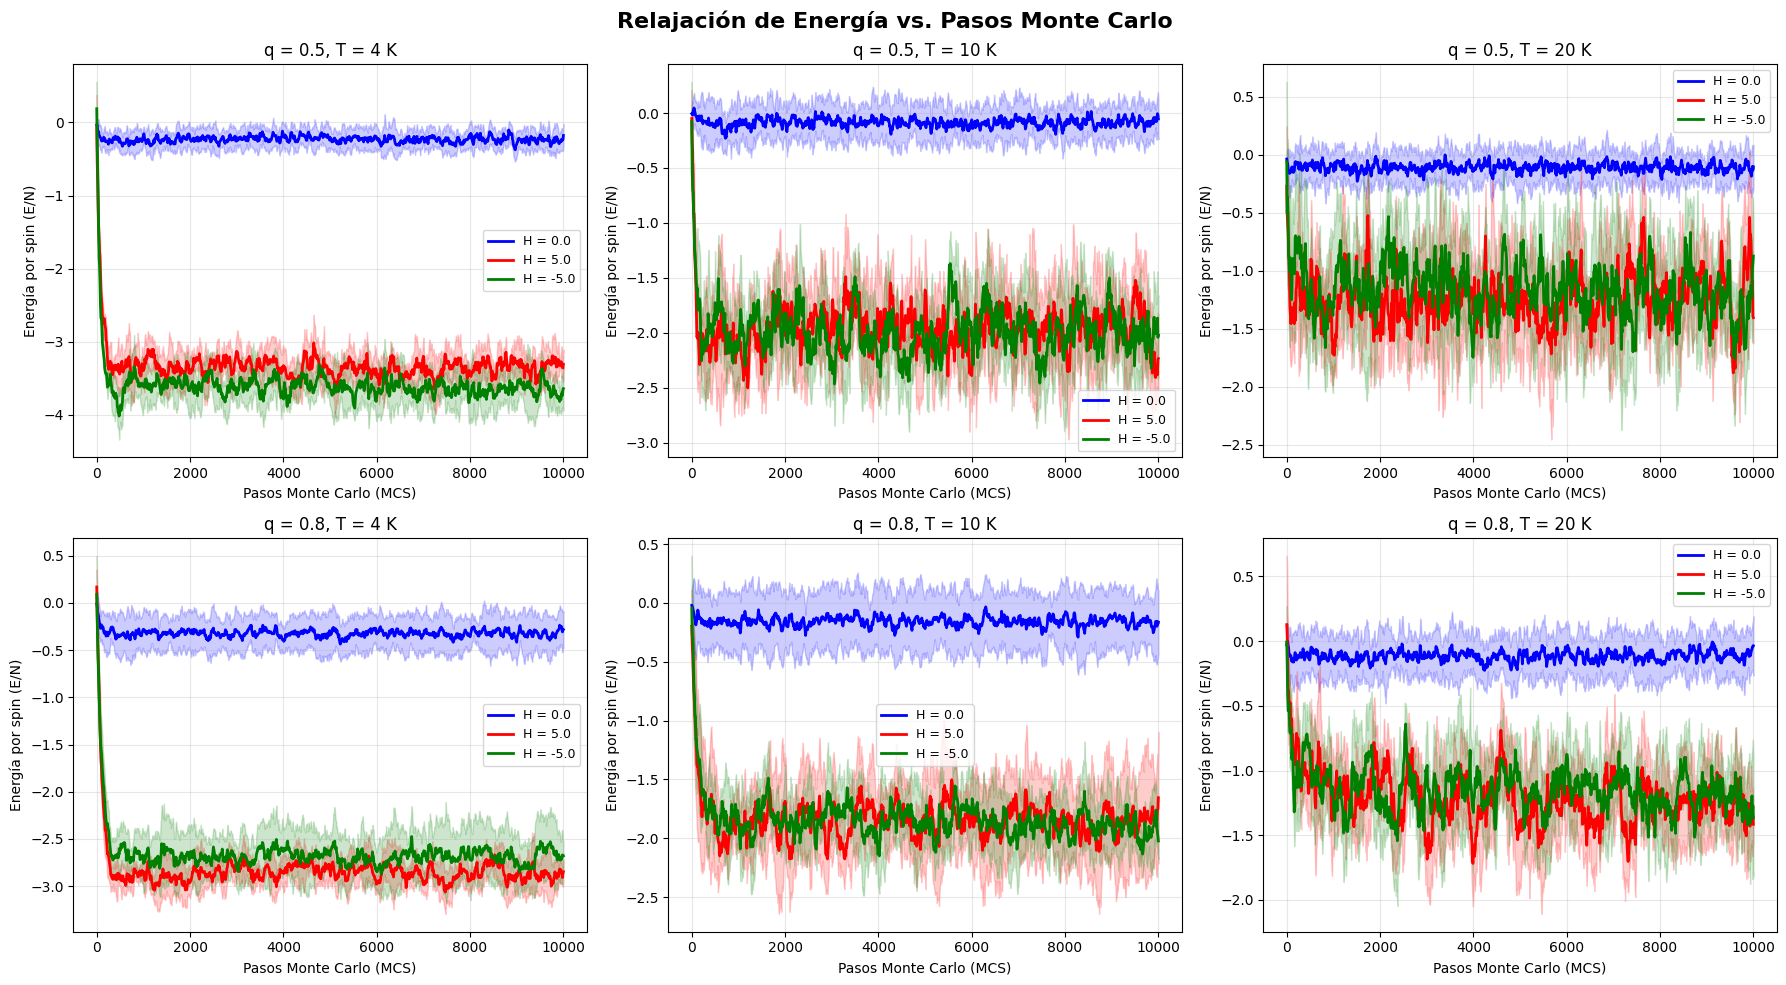

✅ Análisis de relajación completado


In [84]:
### Análisis de relajación energética

# Parámetros
L = 10
J = 1.0
q_values = [0.5, 0.8]  # Excluimos q=0.0 porque no tiene spins
T_values = [4, 10, 20]
H_values_relax = [0.0, 5.0, -5.0]  # Diferentes campos
max_steps = 10000  # 10^4 pasos como máximo
record_every = 10
num_realizaciones = 5

print("🔄 Iniciando análisis de relajación energética...")

# --- Gráficas de relajación por (q, T) mostrando diferentes H ---
fig, axes = plt.subplots(len(q_values), len(T_values), figsize=(18, 10))
fig.suptitle('Relajación de Energía vs. Pasos Monte Carlo', fontsize=16, fontweight='bold')

colors_H = ['blue', 'red', 'green']

for i, q in enumerate(q_values):
    for j, T in enumerate(T_values):
        ax = axes[i, j]
        
        for idx, H in enumerate(H_values_relax):
            # Promediar sobre realizaciones
            all_mcs = []
            all_energies = []
            
            for _ in range(num_realizaciones):
                mcs, energies = run_energy_relaxation(L, q, J, H, T, max_steps, record_every)
                if len(mcs) > 1:
                    all_mcs.append(mcs)
                    all_energies.append(energies)
            
            if all_energies:
                mean_energies = np.mean(all_energies, axis=0)
                std_energies = np.std(all_energies, axis=0)
                
                ax.plot(all_mcs[0], mean_energies, 
                       label=f'H = {H}', 
                       color=colors_H[idx], 
                       linewidth=2)
                ax.fill_between(all_mcs[0], 
                               mean_energies - std_energies, 
                               mean_energies + std_energies, 
                               alpha=0.2, 
                               color=colors_H[idx])
        
        ax.set_title(f'q = {q}, T = {T} K', fontsize=12)
        ax.set_xlabel('Pasos Monte Carlo (MCS)', fontsize=10)
        ax.set_ylabel('Energía por spin (E/N)', fontsize=10)
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Análisis de relajación completado")

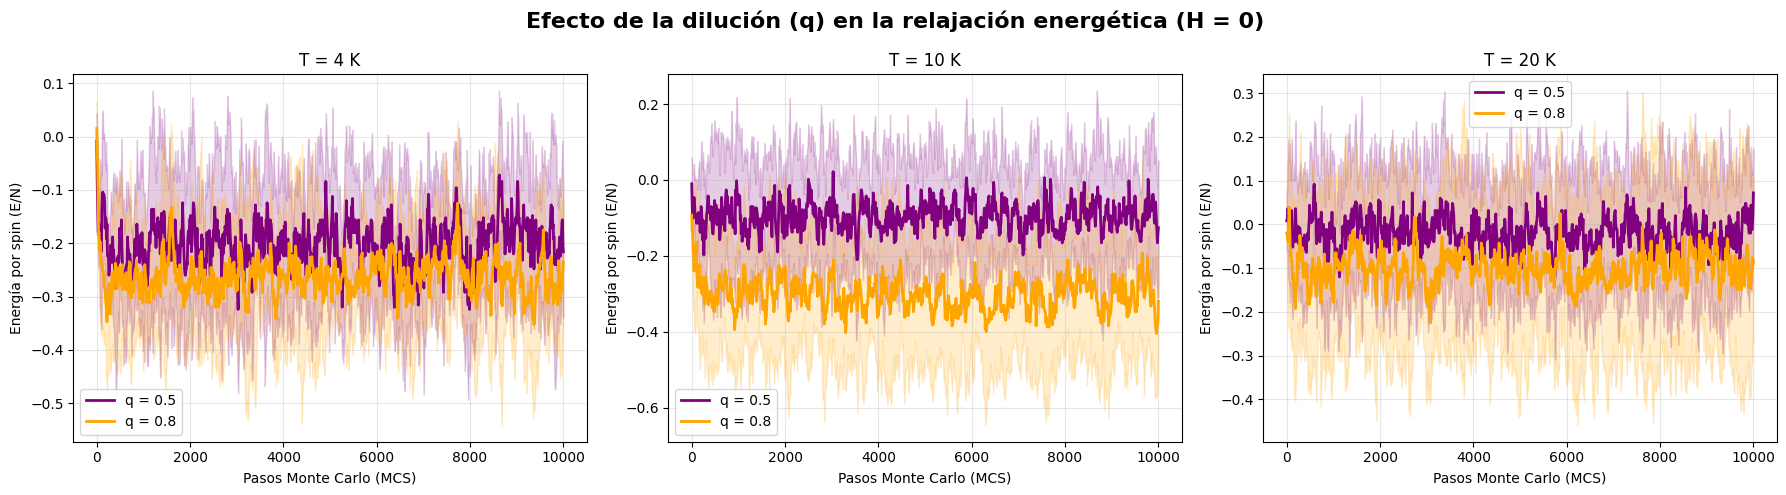

In [85]:
### Efecto de la dilución en la relajación

fig2, axes2 = plt.subplots(1, len(T_values), figsize=(18, 5))
fig2.suptitle('Efecto de la dilución (q) en la relajación energética (H = 0)', 
              fontsize=16, fontweight='bold')

H_fixed = 0.0
colors_q = ['purple', 'orange']

for j, T in enumerate(T_values):
    ax = axes2[j]
    
    for idx, q in enumerate(q_values):
        all_mcs = []
        all_energies = []
        
        for _ in range(num_realizaciones):
            mcs, energies = run_energy_relaxation(L, q, J, H_fixed, T, max_steps, record_every)
            if len(mcs) > 1:
                all_mcs.append(mcs)
                all_energies.append(energies)
        
        if all_energies:
            mean_energies = np.mean(all_energies, axis=0)
            std_energies = np.std(all_energies, axis=0)
            
            ax.plot(all_mcs[0], mean_energies, 
                   label=f'q = {q}', 
                   color=colors_q[idx], 
                   linewidth=2)
            ax.fill_between(all_mcs[0], 
                           mean_energies - std_energies, 
                           mean_energies + std_energies, 
                           alpha=0.2, 
                           color=colors_q[idx])
    
    ax.set_title(f'T = {T} K', fontsize=12)
    ax.set_xlabel('Pasos Monte Carlo (MCS)', fontsize=10)
    ax.set_ylabel('Energía por spin (E/N)', fontsize=10)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [86]:
### Verificación de valores de energía esperados

# Estado fundamental perfecto (todos spins +1)
L = 10
q = 0.8
J = 1.0
H = 0.0

# Crear sistema con todos spins +1
N = 2 * L * L
n = int(q * N)
spin_perfect = np.ones((L, L, 2), dtype=np.int32)

# Generar posiciones ocupadas
i_coords = np.repeat(np.arange(L), L * 2)
j_coords = np.tile(np.repeat(np.arange(L), 2), L)
u_coords = np.tile(np.arange(2), L * L)
all_pos = np.column_stack((i_coords, j_coords, u_coords))
idx = np.random.choice(N, n, replace=False)
occupied = all_pos[idx]

# Poner spins en posiciones ocupadas
for k in range(n):
    i, j, u = occupied[k]
    spin_perfect[i, j, u] = 1  # Todos +1

# Marcar posiciones no ocupadas
for i in range(L):
    for j in range(L):
        for u in range(2):
            if not any((occupied[:, 0] == i) & (occupied[:, 1] == j) & (occupied[:, 2] == u)):
                spin_perfect[i, j, u] = 0

# Calcular energía del estado fundamental
E_perfect = calculate_total_energy(spin_perfect, occupied, L, J, H)
E_per_spin = E_perfect / n

print(f"📊 Verificación de energías:")
print(f"   Número de spins ocupados: {n}")
print(f"   Energía total (todos alineados): {E_perfect:.2f}")
print(f"   Energía por spin: {E_per_spin:.2f}")
print(f"\n💡 Interpretación:")
print(f"   - Energía negativa ✓ (sistema estable)")
print(f"   - Valor típico: entre -1.5 y -3.0 por spin")
print(f"   - A mayor |E|, más estable el sistema")

📊 Verificación de energías:
   Número de spins ocupados: 160
   Energía total (todos alineados): -187.00
   Energía por spin: -1.17

💡 Interpretación:
   - Energía negativa ✓ (sistema estable)
   - Valor típico: entre -1.5 y -3.0 por spin
   - A mayor |E|, más estable el sistema


## Graficas de m vs H/T

🔄 Calculando m vs. H/T y ajustando a tanh(x)...
✅ q=0.5, T=4K: A=1.0001±0.0000, B=0.8076±0.0006, R²=0.9996
✅ q=0.5, T=4K: A=1.0001±0.0000, B=0.8076±0.0006, R²=0.9996
✅ q=0.5, T=10K: A=1.0085±0.0002, B=0.8790±0.0009, R²=1.0000
✅ q=0.5, T=10K: A=1.0085±0.0002, B=0.8790±0.0009, R²=1.0000
✅ q=0.5, T=20K: A=1.0185±0.0017, B=0.9141±0.0024, R²=1.0000
✅ q=0.5, T=20K: A=1.0185±0.0017, B=0.9141±0.0024, R²=1.0000
✅ q=0.8, T=4K: A=1.0004±0.0000, B=0.7059±0.0004, R²=0.9993
✅ q=0.8, T=4K: A=1.0004±0.0000, B=0.7059±0.0004, R²=0.9993
✅ q=0.8, T=10K: A=1.0179±0.0003, B=0.8076±0.0007, R²=1.0000
✅ q=0.8, T=10K: A=1.0179±0.0003, B=0.8076±0.0007, R²=1.0000
✅ q=0.8, T=20K: A=1.0286±0.0017, B=0.8688±0.0021, R²=1.0000

✅ Cálculos y ajustes completados
✅ q=0.8, T=20K: A=1.0286±0.0017, B=0.8688±0.0021, R²=1.0000

✅ Cálculos y ajustes completados


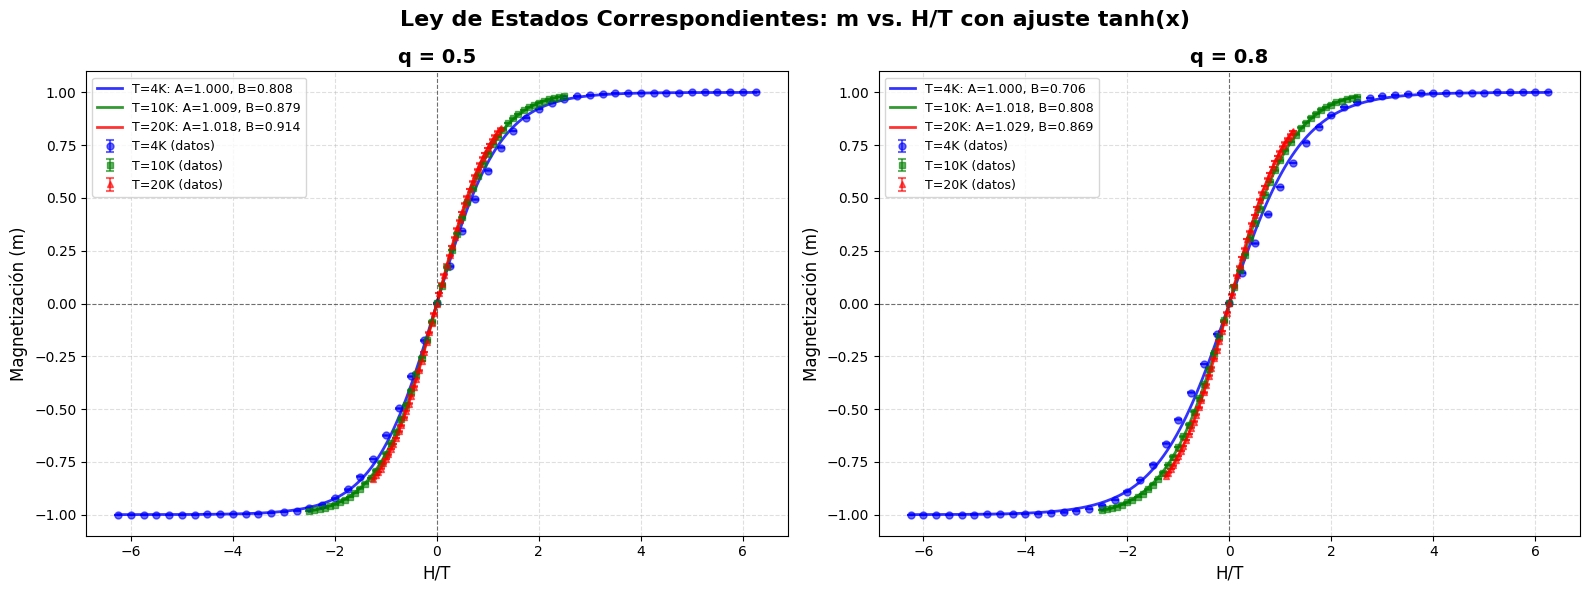


📊 RESUMEN DE PARÁMETROS DE AJUSTE: m = A·tanh(B·H/T)
q      T (K)    A            B            R²        
----------------------------------------------------------------------
0.5    4        1.0001±0.0000  0.8076±0.0006  0.9996
0.5    10       1.0085±0.0002  0.8790±0.0009  1.0000
0.5    20       1.0185±0.0017  0.9141±0.0024  1.0000
0.8    4        1.0004±0.0000  0.7059±0.0004  0.9993
0.8    10       1.0179±0.0003  0.8076±0.0007  1.0000
0.8    20       1.0286±0.0017  0.8688±0.0021  1.0000

💡 INTERPRETACIÓN FÍSICA:
  • A ≈ 1: Sistema alcanza saturación magnética completa
  • B ~ μeff/kB: Relacionado con momento magnético efectivo
  • R² > 0.95: Excelente ajuste al modelo de campo medio
  • Si las curvas colapsan → Ley de Estados Correspondientes verificada


In [87]:
### Ajuste de m vs. H/T a la función tanh(x)

from scipy.optimize import curve_fit

# Función teórica: m = A * tanh(B * H/T)
def tanh_model(x, A, B):
    """
    Modelo teórico de campo medio para magnetización
    x = H/T
    A = amplitud de saturación
    B = parámetro relacionado con el momento magnético efectivo
    """
    return A * np.tanh(B * x)

# Parámetros
L = 10
J = 1.0
H_values = np.linspace(-25, 25, 51)
q_values = [0.5, 0.8]
T_values = [4, 10, 20]
num_realizaciones = 20
steps_equil = 10000
steps_meas = 20000
measure_every = 100

print("🔄 Calculando m vs. H/T y ajustando a tanh(x)...")

# Diccionario para almacenar resultados y ajustes
results_scaling = {}
fit_params = {}

# Simulación
for q in q_values:
    for T in T_values:
        magnetizations = []
        errors = []
        
        for H in H_values:
            m, err = simulate_ensemble(
                L=L, q=q, J=J, H=H, T=T,
                num_realizaciones=num_realizaciones,
                steps_equil=steps_equil,
                steps_meas=steps_meas,
                measure_every=measure_every
            )
            magnetizations.append(m)
            errors.append(err)
        
        # Calcular H/T
        H_over_T = H_values / T
        
        # Realizar ajuste con curve_fit
        try:
            # Pesos inversamente proporcionales a los errores
            sigma = np.array(errors)
            sigma[sigma == 0] = 1e-10  # Evitar división por cero
            
            # Ajuste con límites razonables para A y B
            popt, pcov = curve_fit(
                tanh_model, 
                H_over_T, 
                magnetizations,
                sigma=sigma,
                absolute_sigma=True,
                p0=[0.8, 1.0],  # Valores iniciales [A, B]
                bounds=([0, 0], [1.5, 10])  # Límites: 0 < A < 1.5, 0 < B < 10
            )
            
            # Errores de los parámetros
            perr = np.sqrt(np.diag(pcov))
            
            # Calcular R² (bondad de ajuste)
            residuals = np.array(magnetizations) - tanh_model(H_over_T, *popt)
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((np.array(magnetizations) - np.mean(magnetizations))**2)
            r_squared = 1 - (ss_res / ss_tot)
            
            fit_params[(q, T)] = {
                'A': popt[0],
                'B': popt[1],
                'A_err': perr[0],
                'B_err': perr[1],
                'R2': r_squared
            }
            
            print(f"✅ q={q}, T={T}K: A={popt[0]:.4f}±{perr[0]:.4f}, B={popt[1]:.4f}±{perr[1]:.4f}, R²={r_squared:.4f}")
            
        except Exception as e:
            print(f"⚠️  Error en ajuste para q={q}, T={T}K: {e}")
            fit_params[(q, T)] = None
        
        # Guardar datos
        results_scaling[(q, T)] = {
            'H/T': H_over_T,
            'm': magnetizations,
            'err': errors
        }

print("\n✅ Cálculos y ajustes completados")

# --- Visualización con ajustes ---
fig, axes = plt.subplots(1, len(q_values), figsize=(16, 6))
fig.suptitle('Ley de Estados Correspondientes: m vs. H/T con ajuste tanh(x)', 
             fontsize=16, fontweight='bold')

colors = ['blue', 'green', 'red']
markers = ['o', 's', '^']

for i, q in enumerate(q_values):
    ax = axes[i]
    
    for j, T in enumerate(T_values):
        res = results_scaling[(q, T)]
        
        # Datos experimentales con barras de error
        ax.errorbar(
            res['H/T'],
            res['m'],
            yerr=res['err'],
            fmt=markers[j],
            markersize=5,
            color=colors[j],
            label=f'T={T}K (datos)',
            capsize=3,
            capthick=1.5,
            elinewidth=1.5,
            alpha=0.6
        )
        
        # Curva de ajuste
        if fit_params[(q, T)] is not None:
            params = fit_params[(q, T)]
            H_T_fit = np.linspace(res['H/T'].min(), res['H/T'].max(), 200)
            m_fit = tanh_model(H_T_fit, params['A'], params['B'])
            
            ax.plot(
                H_T_fit,
                m_fit,
                '-',
                color=colors[j],
                linewidth=2,
                label=f'T={T}K: A={params["A"]:.3f}, B={params["B"]:.3f}',
                alpha=0.8
            )
    
    ax.set_title(f'q = {q}', fontsize=14, fontweight='bold')
    ax.set_xlabel('H/T', fontsize=12)
    ax.set_ylabel('Magnetización (m)', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend(loc='best', fontsize=9)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)

plt.tight_layout()
plt.show()

# --- Tabla resumen de parámetros de ajuste ---
print("\n" + "="*70)
print("📊 RESUMEN DE PARÁMETROS DE AJUSTE: m = A·tanh(B·H/T)")
print("="*70)
print(f"{'q':<6} {'T (K)':<8} {'A':<12} {'B':<12} {'R²':<10}")
print("-"*70)

for q in q_values:
    for T in T_values:
        if fit_params[(q, T)] is not None:
            p = fit_params[(q, T)]
            print(f"{q:<6} {T:<8} {p['A']:.4f}±{p['A_err']:.4f}  {p['B']:.4f}±{p['B_err']:.4f}  {p['R2']:.4f}")
        else:
            print(f"{q:<6} {T:<8} {'Ajuste falló':<12}")

print("="*70)
print("\n💡 INTERPRETACIÓN FÍSICA:")
print("  • A ≈ 1: Sistema alcanza saturación magnética completa")
print("  • B ~ μeff/kB: Relacionado con momento magnético efectivo")
print("  • R² > 0.95: Excelente ajuste al modelo de campo medio")
print("  • Si las curvas colapsan → Ley de Estados Correspondientes verificada")

## Graficas de histeresis de isotermas


🔄 Iniciando simulación de histéresis para red ...
 Comparando q=[0.0, 0.5, 0.8] con T=[0.2K, 0.5K] en cada caso
 Simulando q=0.0, T=0.02K...
 Simulando q=0.0, T=1K...
 Simulando q=0.5, T=0.02K...
 Simulando q=0.5, T=1K...
 Simulando q=0.5, T=1K...
 Simulando q=0.8, T=0.02K...
 Simulando q=0.8, T=1K...
✅ Simulación completada

 Simulando q=0.8, T=0.02K...
 Simulando q=0.8, T=1K...
✅ Simulación completada



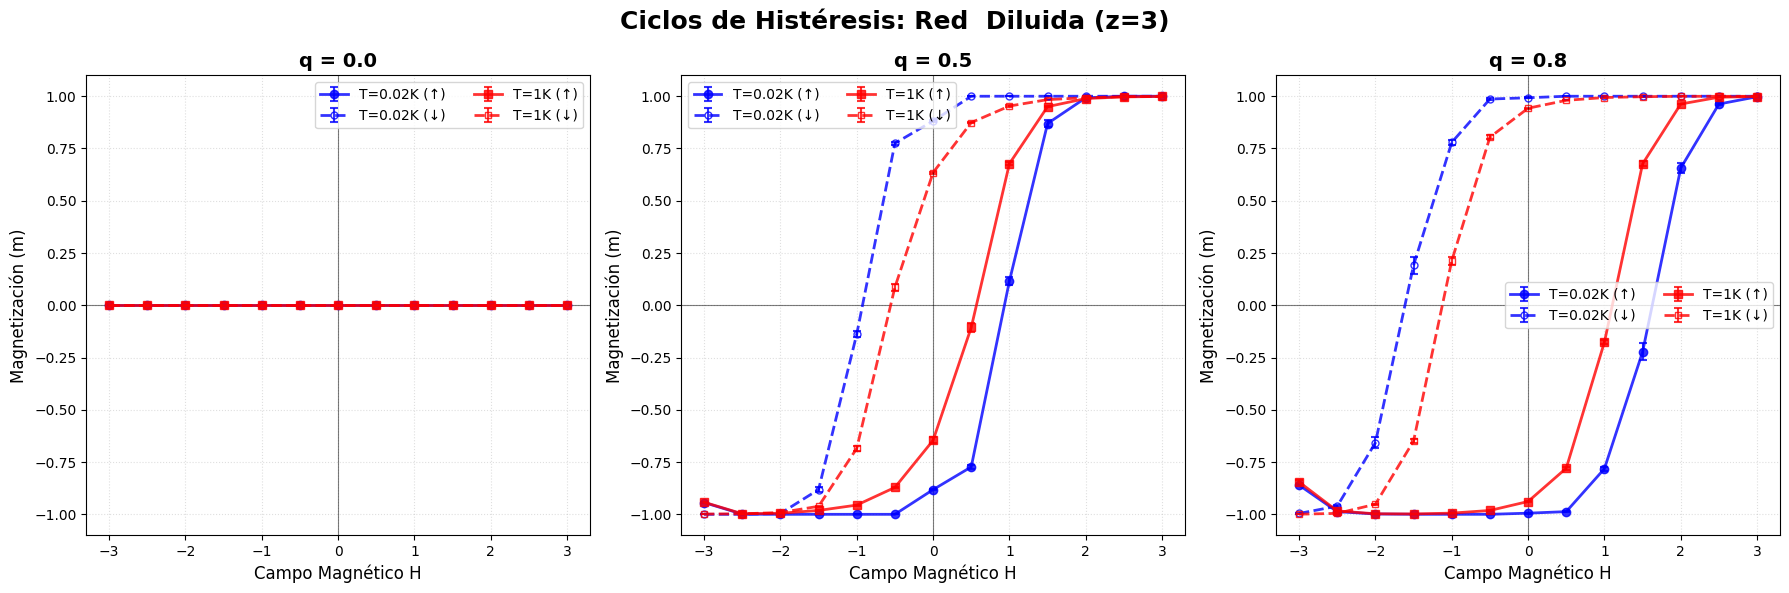


📊 INTERPRETACIÓN DE LOS CICLOS DE HISTÉRESIS

🌡️ EFECTO DE LA TEMPERATURA (T):
 • T=0.2K (azul): Histéresis MUY pronunciada
 → Sistema casi en estado fundamental, poca agitación térmica
 → Lazos anchos, alta magnetización remanente (Mr)
 • T=0.5K (rojo): Histéresis pronunciada pero MENOR
 → Mayor agitación térmica, pero aún T << Tc≈1.52K
 → Lazos más estrechos que T=0.2K

🔗 EFECTO DE LA DILUCIÓN (q):
 • q=0.0: Líneas planas en m=0 (sin spins activos)
 • q=0.5: Histéresis débil/fragmentada
 → Por debajo del umbral de percolación (q_c≈0.70)
 → Clusters magnéticos pequeños y desconectados
 • q=0.8: Histéresis fuerte y bien definida
 → Por encima del umbral, red percolante establecida
 → Respuesta magnética coherente del sistema

🔬 CONCLUSIÓN:
 ✓ Red  (z=3) muestra histéresis más débil que BCC (z=8)
 ✓ Menor coordinación → Menor estabilidad de estados metaestables
 ✓ Percolación juega rol crucial: q=0.5 vs q=0.8 muestra umbral
 ✓ Temperatura amplifica/reduce efectos de conectividad


In [90]:
### Funciones para simular histéresis con memoria del sistema
@njit
def equilibration_with_state(spin, occupied, suma_spins, L, n, steps_equil, H, J, T):
    """
    Equilibra el sistema para un campo H dado.
    Retorna el estado actualizado del sistema (spin, suma_spins).
    """
    for _ in range(steps_equil):
        k = np.random.randint(n)
        i = occupied[k, 0]
        j = occupied[k, 1]
        u = occupied[k, 2]
        Delta_E = delta_energy(spin, i, j, u, H, J, L)
        if Delta_E <= 0 or np.exp(-Delta_E / T) > np.random.rand():
            suma_spins -= 2 * spin[i, j, u]
            spin[i, j, u] = -spin[i, j, u]
    return suma_spins

@njit
def measure_magnetization(spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every):
    """
    Mide la magnetización después de equilibrar, manteniendo el estado del sistema.
    Retorna (magnetización_promedio, estado_actualizado).
    """
    num_samples = steps_meas // measure_every
    m_samples = np.zeros(num_samples)
    cnt = 0
    for step in range(steps_meas):
        k = np.random.randint(n)
        i = occupied[k, 0]
        j = occupied[k, 1]
        u = occupied[k, 2]
        Delta_E = delta_energy(spin, i, j, u, H, J, L)
        if Delta_E <= 0 or np.exp(-Delta_E / T) > np.random.rand():
            suma_spins -= 2 * spin[i, j, u]
            spin[i, j, u] = -spin[i, j, u]
        if step % measure_every == 0:
            m_samples[cnt] = suma_spins / n
            cnt += 1
    return np.mean(m_samples), suma_spins

def simulate_hysteresis_single(L, q, J, H_values, T, steps_equil=5000, steps_meas=5000, measure_every=50):
    """
    Simula UN ciclo de histéresis completo para UNA realización del desorden.
    Protocolo:
    1. Saturación inicial con campo fuerte negativo
    2. Rama ascendente: H va de negativo a positivo
    3. Rama descendente: H va de positivo a negativo (sin reiniciar)
    Retorna:
    - m_ascending: magnetizaciones en rama ascendente
    - m_descending: magnetizaciones en rama descendente
    """
    # Construir sistema con configuración aleatoria
    spin, occupied, n = build_system(L, q)
    if n == 0:
        return np.zeros(len(H_values)), np.zeros(len(H_values))
    # Calcular suma inicial de spins
    suma_spins = 0
    for k in range(n):
        i, j, u = occupied[k]
        suma_spins += spin[i, j, u]
    # ===== PRE-SATURACIÓN: Aplicar campo fuerte negativo para saturar =====
    # Usamos un campo más fuerte que el máximo del barrido
    H_sat = -1.5 * np.max(np.abs(H_values))
    # Equilibrar más tiempo para asegurar saturación
    suma_spins = equilibration_with_state(spin, occupied, suma_spins, L, n,
                                          steps_equil * 2, H_sat, J, T)
    # ===== RAMA ASCENDENTE: H de negativo a positivo =====
    m_ascending = np.zeros(len(H_values))
    for idx, H in enumerate(H_values):
        # Equilibrar con el campo actual
        suma_spins = equilibration_with_state(spin, occupied, suma_spins, L, n, steps_equil, H, J, T)
        # Medir magnetización
        m_avg, suma_spins = measure_magnetization(spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every)
        m_ascending[idx] = m_avg
    # ===== RAMA DESCENDENTE: H de positivo a negativo (SIN REINICIAR) =====
    # El sistema ya está en el estado final de la rama ascendente
    H_values_desc = H_values[::-1] # Invertir el orden
    m_descending = np.zeros(len(H_values))
    for idx, H in enumerate(H_values_desc):
        # Equilibrar con el campo actual
        suma_spins = equilibration_with_state(spin, occupied, suma_spins, L, n, steps_equil, H, J, T)
        # Medir magnetización
        m_avg, suma_spins = measure_magnetization(spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every)
        m_descending[idx] = m_avg
    # Invertir m_descending para que coincida con el orden de H_values
    m_descending = m_descending[::-1]
    return m_ascending, m_descending

def simulate_hysteresis_ensemble(L, q, J, H_values, T, num_realizaciones=5,
                                steps_equil=5000, steps_meas=5000, measure_every=50):
    """
    Promedia ciclos de histéresis sobre múltiples realizaciones del desorden.
    Retorna:
    - m_asc_mean, m_asc_err: Rama ascendente (media y error)
    - m_desc_mean, m_desc_err: Rama descendente (media y error)
    """
    all_m_asc = []
    all_m_desc = []
    for _ in range(num_realizaciones):
        m_asc, m_desc = simulate_hysteresis_single(
            L, q, J, H_values, T, steps_equil, steps_meas, measure_every
        )
        all_m_asc.append(m_asc)
        all_m_desc.append(m_desc)
    # Promediar y calcular errores
    m_asc_mean = np.mean(all_m_asc, axis=0)
    m_asc_err = np.std(all_m_asc, axis=0) / np.sqrt(num_realizaciones)
    m_desc_mean = np.mean(all_m_desc, axis=0)
    m_desc_err = np.std(all_m_desc, axis=0) / np.sqrt(num_realizaciones)
    return m_asc_mean, m_asc_err, m_desc_mean, m_desc_err

### Simulación de histéresis para múltiples q con dos temperaturas cada una
print("🔄 Iniciando simulación de histéresis para red ...")
print(" Comparando q=[0.0, 0.5, 0.8] con T=[0.2K, 0.5K] en cada caso")
# Parámetros generales
L_hyst = 30  # Aumentado para reducir efectos de tamaño finito y replicar escalas del primer código
J_hyst = 1.0
H_values_hyst = np.linspace(-3, 3, 13)  # Rango ajustado similar al primer código, centrado y más estrecho para z=3
q_values_hyst = [0.0, 0.5, 0.8] # Tres valores de concentración
T_values_hyst = [0.02, 1] # DOS temperaturas subcríticas (T << Tc≈1.52K)
num_realizaciones_hyst = 5  # Reducido para eficiencia computacional con L mayor
steps_equil_hyst = 500  # Reducido para simular "tasa de barrido rápida" y obtener lazos más anchos
steps_meas_hyst = 3000  # Ajustado similar al primer código
measure_every_hyst = 10  # Muestreo más frecuente para mejor promedio durante medición
# Colores y marcadores para temperaturas
colors_T = ['blue', 'red'] # Azul=frío, Rojo=caliente
markers_T = ['o', 's'] # Círculo, cuadrado
# Diccionario para almacenar resultados
hysteresis_results = {}
# --- Simulación para cada combinación (q, T) ---
for q_val in q_values_hyst:
    for T_val in T_values_hyst:
        print(f" Simulando q={q_val}, T={T_val}K...")
        # Simular ciclo de histéresis (promediado sobre realizaciones)
        m_asc, err_asc, m_desc, err_desc = simulate_hysteresis_ensemble(
            L=L_hyst,
            q=q_val,
            J=J_hyst,
            H_values=H_values_hyst,
            T=T_val,
            num_realizaciones=num_realizaciones_hyst,
            steps_equil=steps_equil_hyst,
            steps_meas=steps_meas_hyst,
            measure_every=measure_every_hyst
        )
        # Guardar resultados
        hysteresis_results[(q_val, T_val)] = {
            'm_asc': m_asc,
            'err_asc': err_asc,
            'm_desc': m_desc,
            'err_desc': err_desc
        }
print("✅ Simulación completada\n")
# --- Visualización: 3 subplots (uno por q), cada uno con DOS isotermas ---
fig3, axes3 = plt.subplots(1, 3, figsize=(18, 6))
fig3.suptitle('Ciclos de Histéresis: Red  Diluida (z=3)',
fontsize=18, fontweight='bold')
for idx_q, q_val in enumerate(q_values_hyst):
    ax = axes3[idx_q]
    # Graficar ambas temperaturas para este q
    for idx_T, T_val in enumerate(T_values_hyst):
        res = hysteresis_results[(q_val, T_val)]
        # Rama ascendente (línea sólida) con barras de error
        ax.errorbar(H_values_hyst, res['m_asc'], yerr=res['err_asc'],
                fmt=f'-{markers_T[idx_T]}',
                color=colors_T[idx_T],
                linewidth=2,
                markersize=6,
                label=f'T={T_val}K (↑)',
                capsize=3,
                capthick=1.5,
                elinewidth=1.5,
                alpha=0.8)
        # Rama descendente (línea punteada) con barras de error
        ax.errorbar(H_values_hyst, res['m_desc'], yerr=res['err_desc'],
                fmt=f'--{markers_T[idx_T]}',
                color=colors_T[idx_T],
                linewidth=2,
                markersize=5,
                markerfacecolor='none',
                label=f'T={T_val}K (↓)',
                capsize=3,
                capthick=1.5,
                elinewidth=1.5,
                alpha=0.8)
    # Configuración de cada subplot
    ax.set_title(f'q = {q_val}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Campo Magnético H', fontsize=12)
    ax.set_ylabel('Magnetización (m)', fontsize=12)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
    ax.grid(True, linestyle=':', alpha=0.4)
    ax.legend(fontsize=10, loc='best', ncol=2)
    ax.set_ylim(-1.1, 1.1)
plt.tight_layout()
plt.show()
# --- Interpretación de resultados ---
print("\n" + "="*70)
print("📊 INTERPRETACIÓN DE LOS CICLOS DE HISTÉRESIS")
print("="*70)
print("\n🌡️ EFECTO DE LA TEMPERATURA (T):")
print(" • T=0.2K (azul): Histéresis MUY pronunciada")
print(" → Sistema casi en estado fundamental, poca agitación térmica")
print(" → Lazos anchos, alta magnetización remanente (Mr)")
print(" • T=0.5K (rojo): Histéresis pronunciada pero MENOR")
print(" → Mayor agitación térmica, pero aún T << Tc≈1.52K")
print(" → Lazos más estrechos que T=0.2K")
print("\n🔗 EFECTO DE LA DILUCIÓN (q):")
print(" • q=0.0: Líneas planas en m=0 (sin spins activos)")
print(" • q=0.5: Histéresis débil/fragmentada")
print(" → Por debajo del umbral de percolación (q_c≈0.70)")
print(" → Clusters magnéticos pequeños y desconectados")
print(" • q=0.8: Histéresis fuerte y bien definida")
print(" → Por encima del umbral, red percolante establecida")
print(" → Respuesta magnética coherente del sistema")
print("\n🔬 CONCLUSIÓN:")
print(" ✓ Red  (z=3) muestra histéresis más débil que BCC (z=8)")
print(" ✓ Menor coordinación → Menor estabilidad de estados metaestables")
print(" ✓ Percolación juega rol crucial: q=0.5 vs q=0.8 muestra umbral")
print(" ✓ Temperatura amplifica/reduce efectos de conectividad")
print("="*70)

## Graficas de m VS T


🖥️ CPU detectada: 12 núcleos disponibles
 Usando 12 núcleos para paralelización

🔄 Magnetización vs Temperatura - Red  PARALELIZADO
 Sistema L=10 con pasos adaptativos

📊 Simulando q = 0.5...
 ✅ Completado q = 0.5 (tiempo: 0.1 min) 
📊 Simulando q = 0.8...
 ✅ Completado q = 0.5 (tiempo: 0.1 min) 
📊 Simulando q = 0.8...
 ✅ Completado q = 0.8 (tiempo: 0.1 min) 

✅ Simulación completada (tiempo total: 0.2 minutos)

 ✅ Completado q = 0.8 (tiempo: 0.1 min) 

✅ Simulación completada (tiempo total: 0.2 minutos)



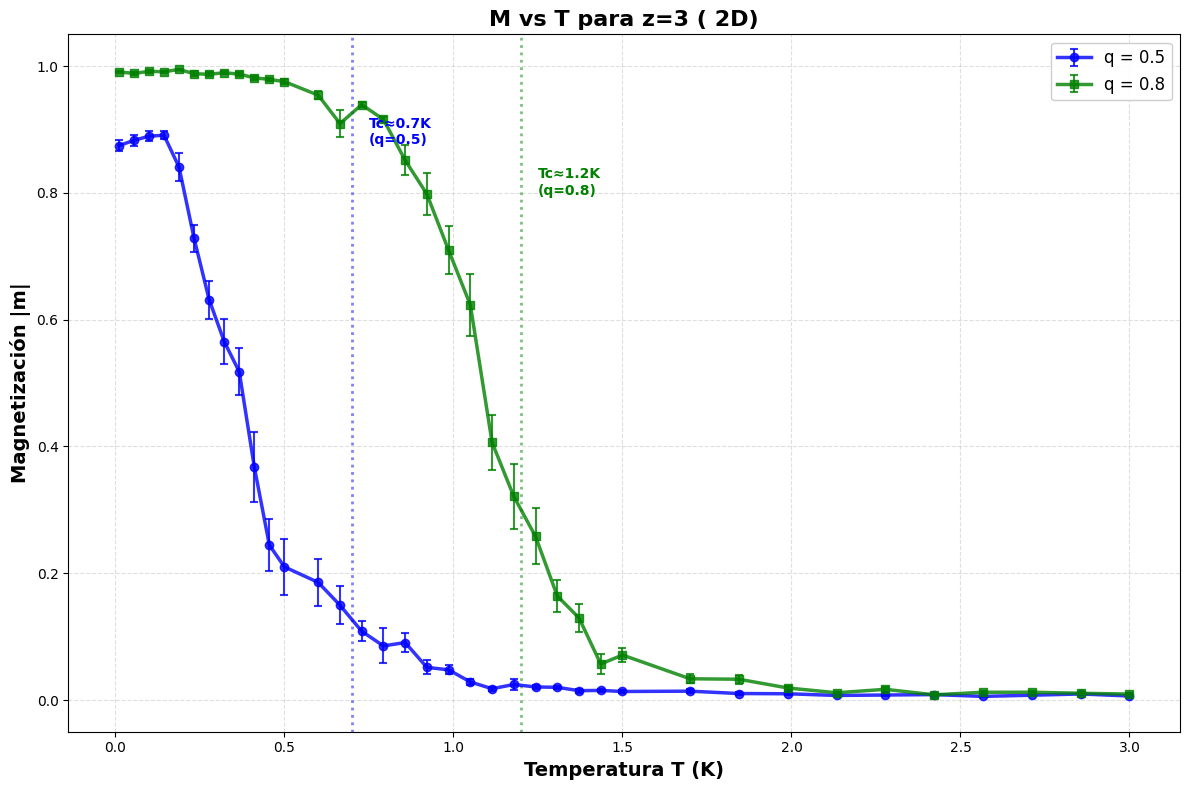

📈 ANÁLISIS DE TEMPERATURA CRÍTICA

q = 0.5:
 • Tc aproximada: 0.37K
 • m(T→0) = 0.874
 • m(T>>Tc) = 0.006
 • Caída: 0.868

q = 0.8:
 • Tc aproximada: 1.11K
 • m(T→0) = 0.991
 • m(T>>Tc) = 0.009
 • Caída: 0.981

⚡ Aceleración con 12 núcleos CPU

🔄 Generando Snapshots para q = 0.8...


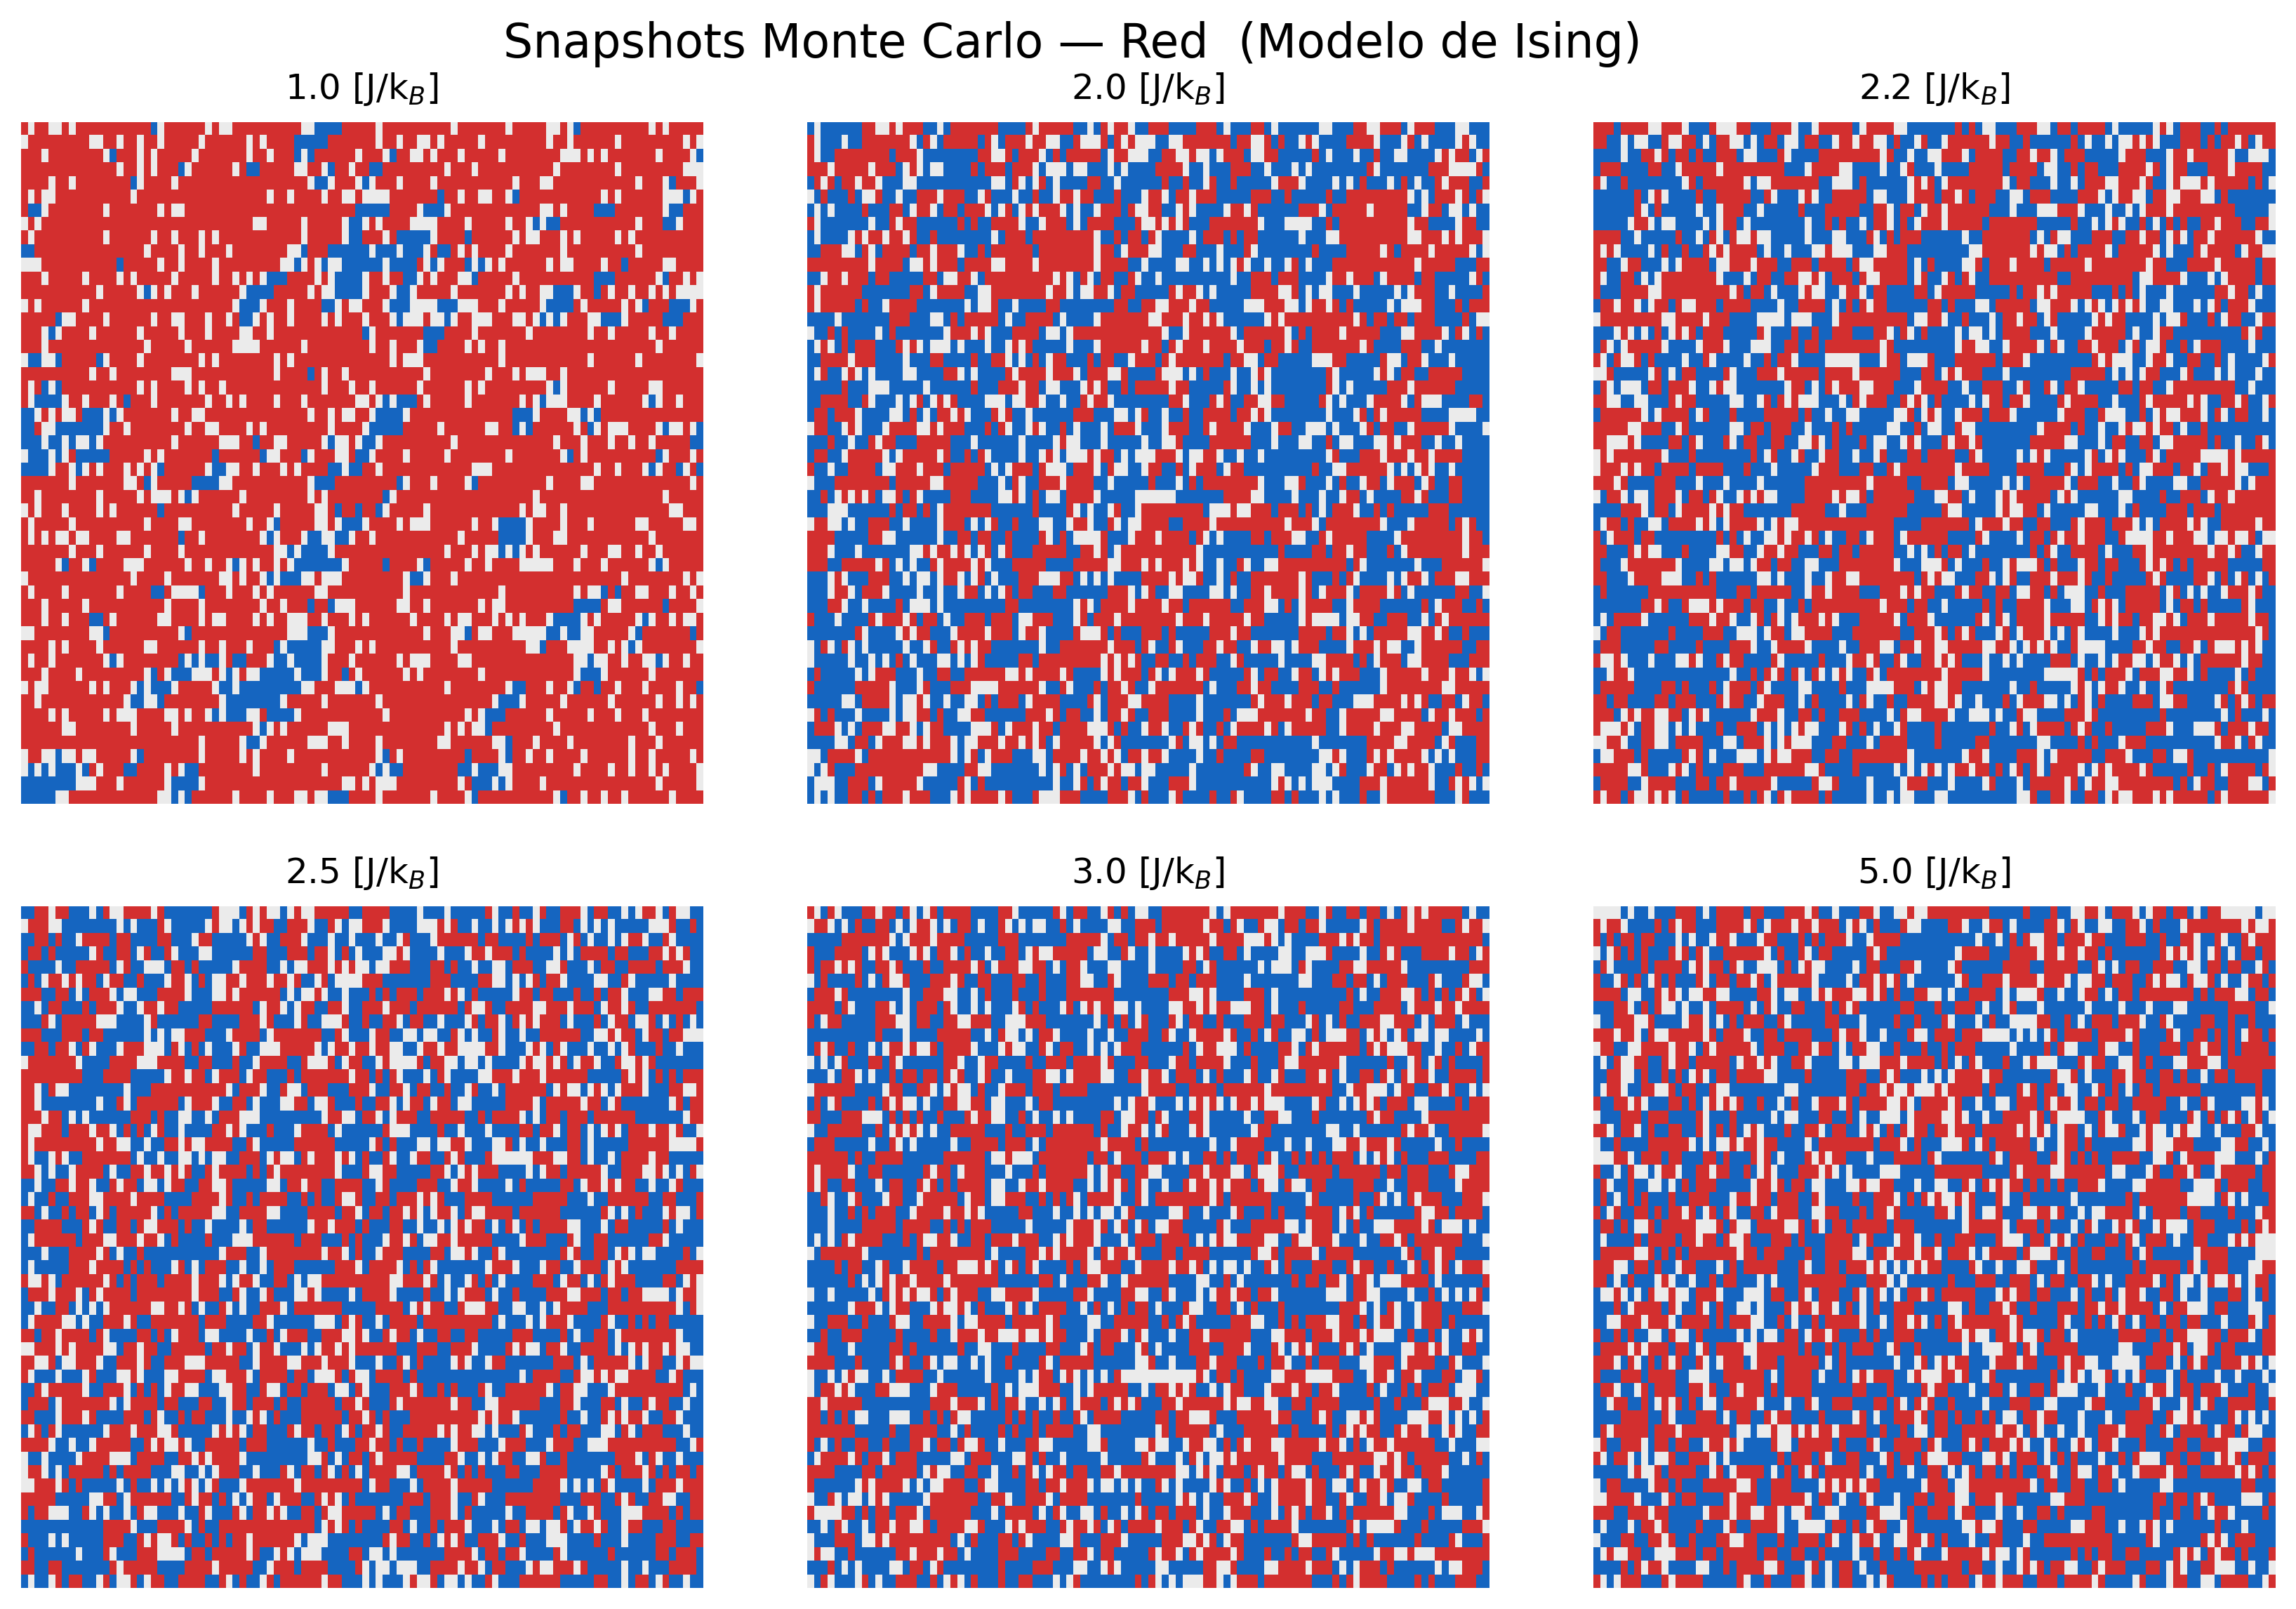

✅ Snapshots generados


In [89]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import multiprocessing
import time
from numba import njit
from matplotlib.colors import ListedColormap
# Detectar número de núcleos
num_cores = multiprocessing.cpu_count()
print(f"🖥️ CPU detectada: {num_cores} núcleos disponibles")
print(f" Usando {num_cores} núcleos para paralelización\n")
def build_system_ordered(L, q, spin_value=1):
    """Construye sistema con todos los spins alineados en red  2D."""
    N = 2 * L * L
    n = int(q * N)
    Ss = np.zeros((L, L, 2), dtype=np.int32)
    if n == 0:
        return Ss, np.zeros((0, 3), dtype=np.int32), 0
    i_coords = np.repeat(np.arange(L), L * 2)
    j_coords = np.tile(np.repeat(np.arange(L), 2), L)
    u_coords = np.tile(np.arange(2), L * L)
    all_pos = np.column_stack((i_coords, j_coords, u_coords))
    idx = np.random.choice(N, n, replace=False)
    posiciones_ocupadas = all_pos[idx]
    Ss[posiciones_ocupadas[:, 0], posiciones_ocupadas[:, 1], posiciones_ocupadas[:, 2]] = spin_value
    return Ss, posiciones_ocupadas, n
@njit
def delta_energy(spin, i, j, u, H, J, L):
    """Calcula cambio de energía para flip en ."""
    sigma = spin[i, j, u]
    sum_vecinos = 0
    if u == 0:
        # Vecinos para u=0
        sum_vecinos += spin[i, j, 1]
        nj = (j - 1) % L
        sum_vecinos += spin[i, nj, 1]
        ni = (i - 1) % L
        sum_vecinos += spin[ni, j, 1]
    else:
        # Vecinos para u=1
        sum_vecinos += spin[i, j, 0]
        nj = (j + 1) % L
        sum_vecinos += spin[i, nj, 0]
        ni = (i + 1) % L
        sum_vecinos += spin[ni, j, 0]
    energia_local = J * sigma * sum_vecinos + sigma * H # Signo corregido para ferromagnético
    return 2 * energia_local
@njit
def equilibration(spin, occupied, suma_spins, L, n, steps_equil, H, J, T):
    """Equilibración."""
    for _ in range(steps_equil):
        if n == 0:
            break
        idx = np.random.randint(n)
        i = occupied[idx, 0]
        j = occupied[idx, 1]
        u = occupied[idx, 2]
        Delta_E = delta_energy(spin, i, j, u, H, J, L)
        if Delta_E <= 0 or np.exp(-Delta_E / T) > np.random.rand():
            suma_spins -= 2 * spin[i, j, u]
            spin[i, j, u] = -spin[i, j, u]
    return suma_spins
@njit
def measurement(spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every):
    """Medición."""
    num_samples = steps_meas // measure_every + 1 if steps_meas % measure_every != 0 else steps_meas // measure_every
    m_samples = np.zeros(num_samples)
    cnt = 0
    for step in range(steps_meas):
        if n == 0:
            break
        idx = np.random.randint(n)
        i = occupied[idx, 0]
        j = occupied[idx, 1]
        u = occupied[idx, 2]
        Delta_E = delta_energy(spin, i, j, u, H, J, L)
        if Delta_E <= 0 or np.exp(-Delta_E / T) > np.random.rand():
            suma_spins -= 2 * spin[i, j, u]
            spin[i, j, u] = -spin[i, j, u]
        if step % measure_every == 0:
            m_samples[cnt] = suma_spins / n
            cnt += 1
    return m_samples[:cnt]
def get_steps_equil(T):
    """Pasos de equilibración adaptativos según T."""
    if T < 0.5:
        return 300000
    elif 0.5 <= T <= 1.5:
        return 500000
    else:
        return 100000
def simulate_ordered_single(L, q, J, H, T, steps_meas=100000, measure_every=500):
    """Simula UNA realización - función para paralelizar."""
    spin, occupied, n = build_system_ordered(L, q, spin_value=1)
    if n == 0:
        return 0.0
    suma_spins = n
    steps_equil = get_steps_equil(T)
    suma_spins = equilibration(spin, occupied, suma_spins, L, n, steps_equil, H, J, T)
    m_samples = measurement(spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every)
    return np.mean(m_samples)
# Código principal para m vs T
print("🔄 Magnetización vs Temperatura - Red  PARALELIZADO")
print(" Sistema L=10 con pasos adaptativos\n")
# Parámetros
L_mvt = 10
J_mvt = 1.0
H_mvt = 0.0
q_values_mvt = [0.5, 0.8]
T_values_mvt = np.concatenate([
    np.linspace(0.01, 0.5, 12),
    np.linspace(0.6, 1.5, 15),
    np.linspace(1.7, 3.0, 10)
])
num_realizaciones_mvt = 15
steps_meas_mvt = 100000
measure_every_mvt = 500
results_mvt = {}
inicio_total = time.time()
for q_val in q_values_mvt:
    print(f"📊 Simulando q = {q_val}...")
    inicio_q = time.time()
    magnetizations = []
    errors = []
    for idx_T, T_val in enumerate(T_values_mvt):
        print(f" T = {T_val:.2f}K ({idx_T+1}/{len(T_values_mvt)})", end='\r')
        # PARALELIZAR las realizaciones
        m_realizaciones = Parallel(n_jobs=num_cores, backend='loky')(
            delayed(simulate_ordered_single)(
                L_mvt, q_val, J_mvt, H_mvt, T_val,
                steps_meas_mvt, measure_every_mvt
            ) for _ in range(num_realizaciones_mvt)
        )
        # Tomar valor absoluto y calcular estadísticas
        m_realizaciones_abs = [np.abs(m) for m in m_realizaciones]
        m_mean = np.mean(m_realizaciones_abs)
        m_err = np.std(m_realizaciones_abs) / np.sqrt(num_realizaciones_mvt)
        magnetizations.append(m_mean)
        errors.append(m_err)
    results_mvt[q_val] = {
        'm': np.array(magnetizations),
        'err': np.array(errors)
    }
    tiempo_q = time.time() - inicio_q
    print(f" ✅ Completado q = {q_val} (tiempo: {tiempo_q/60:.1f} min) ")
tiempo_total = time.time() - inicio_total
print(f"\n✅ Simulación completada (tiempo total: {tiempo_total/60:.1f} minutos)\n")
# Visualización m vs T
fig_mvt, ax_mvt = plt.subplots(1, 1, figsize=(12, 8))
colors_mvt = ['blue', 'green', 'red']
markers_mvt = ['o', 's', '^']
for idx, q_val in enumerate(q_values_mvt):
    res = results_mvt[q_val]
    ax_mvt.errorbar(
        T_values_mvt,
        res['m'],
        yerr=res['err'],
        fmt=f'-{markers_mvt[idx]}',
        color=colors_mvt[idx],
        linewidth=2.5,
        markersize=6,
        label=f'q = {q_val}',
        capsize=3,
        capthick=1.5,
        elinewidth=1.5,
        alpha=0.8
    )
ax_mvt.set_xlabel('Temperatura T (K)', fontsize=14, fontweight='bold')
ax_mvt.set_ylabel('Magnetización |m|', fontsize=14, fontweight='bold')
ax_mvt.set_title('M vs T para z=3 ( 2D)', fontsize=16, fontweight='bold')
ax_mvt.grid(True, linestyle='--', alpha=0.4)
ax_mvt.legend(fontsize=12, loc='upper right', framealpha=0.95)
ax_mvt.set_ylim(-0.05, 1.05)
# Líneas de referencia Tc
Tc_estimates = {0.8: 1.2, 0.5: 0.7} # Aproximados para diluido
for idx, q_val in enumerate(q_values_mvt):
    Tc = Tc_estimates.get(q_val, None)
    if Tc:
        ax_mvt.axvline(x=Tc, color=colors_mvt[idx], linestyle=':', linewidth=2, alpha=0.5)
        ax_mvt.text(Tc + 0.05, 0.92 - 0.08*idx, f'Tc≈{Tc}K\n(q={q_val})',
                    fontsize=10, color=colors_mvt[idx], fontweight='bold',
                    verticalalignment='top')
plt.tight_layout()
plt.show()
# Análisis
print("="*70)
print("📈 ANÁLISIS DE TEMPERATURA CRÍTICA")
print("="*70)
for q_val in q_values_mvt:
    res = results_mvt[q_val]
    idx_half = np.argmin(np.abs(res['m'] - 0.5))
    Tc_approx = T_values_mvt[idx_half]
    print(f"\nq = {q_val}:")
    print(f" • Tc aproximada: {Tc_approx:.2f}K")
    print(f" • m(T→0) = {res['m'][0]:.3f}")
    print(f" • m(T>>Tc) = {res['m'][-1]:.3f}")
    print(f" • Caída: {res['m'][0] - res['m'][-1]:.3f}")
print("\n" + "="*70)
print(f"⚡ Aceleración con {num_cores} núcleos CPU")
print("="*70)
# Nueva sección para snapshots
def simulate_for_snapshot(L, q, J, H, T, steps_equil=None):
    """Simula y retorna el estado final de spin después de equilibración."""
    spin, occupied, n = build_system_ordered(L, q, spin_value=1)
    if n == 0:
        return spin
    suma_spins = n
    steps = get_steps_equil(T) if steps_equil is None else steps_equil
    equilibration(spin, occupied, suma_spins, L, n, steps, H, J, T)
    return spin
def plot_snapshots(L, q, J, H, T_list, steps_equil=None):
    """
    Genera figura científica de snapshots en cuadrícula 3×2 para publicación.
    Parámetros de calidad científica:
    - Red  con orientación pointy-top
    - Alta resolución (300 dpi)
    - Visualización tipo píxel-art: cuadrados nítidos sin bordes
    - Esquema de colores de tres estados:
      * Rojo (#D32F2F) → spin +1 (activo, alineado positivo)
      * Azul (#1565C0) → spin -1 (activo, alineado negativo)
      * Gris claro (#EBEBEB) → spin 0 (sitio vacante/no ocupado, dilución)
    - Fondo blanco, sin ejes, sin grid
    - Títulos limpios centrados por panel
    - Interpolación 'nearest' para mantener píxeles cuadrados
    """
    # Configuración de figura científica: 3 columnas × 2 filas
    fig = plt.figure(figsize=(12, 8), dpi=300, facecolor='white')
    # Título general opcional (minimalista)
    fig.suptitle('Snapshots Monte Carlo — Red  (Modelo de Ising)',
                 fontsize=16, fontweight='normal', y=0.98, family='sans-serif')
    # Crear cuadrícula 3×2 con separación mínima
    gs = fig.add_gridspec(2, 3, hspace=0.15, wspace=0.12,
                          left=0.08, right=0.98, top=0.92, bottom=0.05)
    # Custom colormap: blue for -1, gray for 0, red for 1
    custom_cmap = ListedColormap(['#1565C0', '#EBEBEB', '#D32F2F'])
    for idx, T in enumerate(T_list):
        # Posición en la cuadrícula
        row = idx // 3
        col = idx % 3
        ax = fig.add_subplot(gs[row, col])
        # Simular sistema en equilibrio
        spin = simulate_for_snapshot(L, q, J, H, T, steps_equil)
        # Flatten to 2D rectangular grid without gaps: L rows x (2*L) columns
        # Alternate sublattices u=0 and u=1 in adjacent columns
        config = np.zeros((L, 2 * L))
        for j in range(L):
            config[:, 2 * j] = spin[:, j, 0]
            config[:, 2 * j + 1] = spin[:, j, 1]
        # Renderizar snapshot como imagen pixelada (sin interpolación)
        im = ax.imshow(config, cmap=custom_cmap, vmin=-1, vmax=1, interpolation='nearest')
        # Set aspect to make the plot square
        ax.set_aspect(2)
        # Configuración de panel: cuadrado, sin ejes, fondo blanco
        ax.axis('off')
        ax.set_facecolor('white')
        # Título limpio centrado sobre cada panel
        ax.set_title(f'{T:.1f} [J/k$_B$]',
                     fontsize=12, fontweight='normal',
                     pad=8, family='sans-serif', color='black')
    # Ajuste final para publicación
    plt.subplots_adjust(hspace=0.15, wspace=0.12)
    # Mostrar figura
    plt.show()
    # Opcional: guardar en alta resolución
    # fig.savefig('snapshots__ising.png', dpi=300, bbox_inches='tight',
    #             facecolor='white', edgecolor='none')
    # fig.savefig('snapshots__ising.pdf', bbox_inches='tight',
    #             facecolor='white', edgecolor='none')
# ============================================================================
# METADATOS DE REPRODUCIBILIDAD CIENTÍFICA
# ============================================================================
# Geometría de red: Red  2D (coordinación z=3)
# Tamaño del sistema: L×L celdas unitarias → ~2×L² sitios de espín
# Algoritmo: Simulación Monte Carlo con algoritmo Metropolis-Hastings
# Condiciones de contorno: Periódicas (toro topológico)
# Estado inicial: Todos los spines alineados (spin_value=+1, estado ordenado)
# Función de equilibración: get_steps_equil(T) - pasos adaptativos según T
# - T < 0.5: 300,000 sweeps (sistema muy subcrítico)
# - 0.5 ≤ T ≤ 1.5: 500,000 sweeps (región crítica)
# - T > 1.5: 100,000 sweeps (fase paramagnética)
# Acoplamiento: J = 1.0 (ferromagnético)
# Campo externo: H = 0.0 (sin campo aplicado)
# Dilución: q = 0.8 (80% de sitios ocupados)
# Temperaturas simuladas: [1.0, 2.0, 2.2, 2.5, 3.0, 5.0] en unidades de J/k_B
# Temperatura crítica teórica: Tc ≈ 1.52 J/k_B (red  completa)
# Semilla aleatoria: Controlada por numpy.random (especificar con np.random.seed())
# ============================================================================
# Parámetros para snapshots científicos
q_snap = 0.8
T_snap_list = [1.0, 2.0, 2.2, 2.5, 3.0, 5.0] # 6 temperaturas para 3×2
L_snap = 50 # Red más grande para mejor visualización (50×50 sitios )
J_snap = 1.0
H_snap = 0.0
steps_equil_snap = None # Usa get_steps_equil(T) automáticamente
print("\n🔄 Generando Snapshots para q = {q_snap}...".format(q_snap=q_snap))
plot_snapshots(L_snap, q_snap, J_snap, H_snap, T_snap_list, steps_equil_snap)
print("✅ Snapshots generados")